In [1]:
import os
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 96

import scipy.stats

import seldon.ambiguity.posterior as posterior
from seldon.inference import BayesianInference, Posterior

In [2]:
# Observations

#ns = np.array([10, 1, 1])
ns = np.array([5, 0, 0])
#ns = np.array([10, 0, 0])
#ns = np.array([30, 0, 0])
#ns = np.array([0, 0, 7])

In [3]:
# Choice of prior
beta: float = 1

# Choice of ambiguity measure
modified: bool = False

In [4]:
inference_object = (
    BayesianInference
    .specify(
        posterior.ModifiedNewAmbiguityPosterior
        if modified
        else posterior.NewAmbiguityPosterior
    )
)(beta=beta).fit(ns)

In [5]:
ambs_grid = np.linspace(0, 1, 1001)
ambs_left = ambs_grid[:-1]
ambs_right = ambs_grid[1:]
ambs = (ambs_left + ambs_right) / 2
dambs = ambs_right - ambs_left
density = inference_object.posterior.pdf(ambs)

unit_mass = np.sum(
    dambs * density
)

exp_amb = np.sum(dambs * ambs * density)
idx_closest_on_grid = np.abs(ambs - exp_amb).argmin()
exp_corresponding_density = density[idx_closest_on_grid]

unit_mass.item()

0.9999656101495032

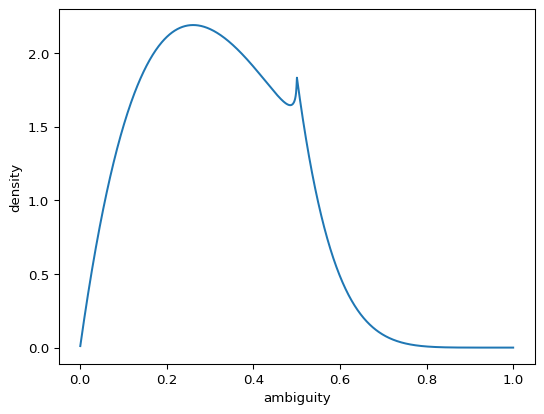

In [6]:
fig, ax = plt.subplots()
ax.plot(ambs, inference_object.posterior.pdf(ambs))
ax.set_xlabel("ambiguity")
ax.set_ylabel("density")
plt.show()

## An analytical expression in the case of $C+1=3$ [**DEPRECATED**]

In [7]:
def compute_xi(ambs: np.ndarray, us: np.ndarray, modified: bool = False) -> np.ndarray:
    # ambs: (M,)
    # us: (N,)
    dd = (1 - ambs.reshape(-1, 1)) / (1 - us)
    if not modified:
        dd = 2 * dd - 1
    # dd: (M, N)
    return np.permute_dims(1/2 * (
        # (M, N, 2)
        1 + np.array([1, -1]) * np.expand_dims(np.sqrt(np.maximum(0, dd)), axis=-1)
    ), (2, 0, 1))


def compute_dxi_da(ambs: np.ndarray, us: np.ndarray, modified: bool = False) -> np.ndarray:
    # ambs: (M,)
    # us: (N,)
    denom_squared = (1 - ambs).reshape(-1, 1) * (1 - us)
    factor = 1/4
    if not modified:
        denom_squared = np.maximum(1e-7, denom_squared + (
            (us - ambs.reshape(-1, 1)) * (1 - us)
        ))
        factor *= 2
    return np.permute_dims(factor * np.array([-1, 1]) * np.expand_dims(1 / np.sqrt(denom_squared), axis=-1), (2, 0, 1))

In [8]:
def amb_density(ambs: np.ndarray, alphas: list[float], modified: bool = False):
    # ambs: (M,)
    g_ambs = np.maximum(0, 2 * ambs  - 1)
    
    # Concentration parameters
    assert len(alphas) == 3
    a_a, a_b, a_cs = alphas
    
    # Define grid over u
    us_grid = np.linspace(0, 1, 10001)
    us_left = us_grid[:-1]
    us_right = us_grid[1:]
    us = (us_left + us_right) / 2
    du = us_right - us_left
    is_valid = us_right <= ambs.reshape(-1, 1)
    if not modified:
        is_valid = np.logical_and(
            is_valid,
            us_left >= g_ambs.reshape(-1, 1)
        )
    
    # us, du: (N,)
    # is_valid: (M, N)
    
    # Compute xi± and its derivatives with respect to ambiguity value
    xi_plus, xi_minus = compute_xi(ambs, us, modified=modified)
    dxi_plus, *_ = compute_dxi_da(ambs, us, modified=modified)
    # xi_{plus,minus}: (M, N)
    # dxi_plus: (M, N)
    
    beta_pdf = scipy.stats.beta.pdf
    # beta_cdf = scipy.stats.beta.cdf
    
    # pdf_a = beta_pdf(ambs, a=a_cs, b=a_a+a_b)
    pdf_u = beta_pdf(us, a=a_cs, b=a_a+a_b)
    # cdf_plus = beta_cdf(xi_plus, a=a_a, b=a_b)
    # cdf_minus = beta_cdf(xi_minus, a=a_a, b=a_b)
    pdf_plus = beta_pdf(xi_plus, a=a_a, b=a_b)
    pdf_minus = beta_pdf(xi_minus, a=a_a, b=a_b)
    # pdf_a: (M,), pdf_u: (N,)
    # cdf_{plus,minus}: (M, N)
    # pdf_{plus,minus}: (M, N)
    
    # Stitch it together
    integral = -np.sum(
        pdf_u * du
        * is_valid * dxi_plus * (
            pdf_plus + pdf_minus
        ),
        axis=-1
    )
        
    # integral: (M,)
        
    return integral